In [98]:
# IO
import sys, re, csv, os
from collections import Counter
# WEB-SCRAPPING
from bs4 import BeautifulSoup
import requests
import html5lib
from time import sleep
import json
from dateutil.parser import parse
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
# TWITTER
from twython import Twython
from twython import TwythonStreamer

### OFFLINE DATA

In [4]:
# INPUT HANDLING

#   1. read, filter-write lines that fit regex.
regex = sys.argv[1]
for line in sys.stdin:
    if re.search(regex, line):
        sys.stdout.write(line)
#   2. count number of lines.
count = 0
for line in sys.stdin:
    count += 1
print count
# usage (in command line)
#   cat input_file.txt | python script.py 'regex'

#   3. output n most common words.
try:
    numWords = int(sys.argv[1])
except: 
    print 'usage: most_common_words.py numWords'
    sys.exit(1) # nonzero exit code indicates error.
counter = Counter(word.lower() for line in sys.stdin for word in line.strip().split() if word)
for word, count in counter.most_common(numWords):
    sys.stdout.write(str(count))
    sys.stdout.write('\t')
    sys.stdout.write(word)
    sys.stdout.write('\n')
# usage
#   cat input_file.txt | python script.py numWords

0
usage: most_common_words.py numWords


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.


In [10]:
# FILE IO 1
''' file1.txt (headerless)
6/20/2014       AAPL    90.91
6/20/2014       MSFT    41.68
6/20/2014       FB      64.5
6/19/2014       AAPL    91.96
6/19/2014       MSFT    41.51
6/19/2014       FB      64.34
'''
os.chdir('/Users/su/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/DATA')
print 'Processing... file2.txt'
with open('file1.txt', 'r') as f:
    # r vs. rb: only different in Windows.
    # r writes 2 bytes, rb 1 byte.
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        date = row[0]
        symbol = row[1]
        closingPrice = float(row[2])
        # process(date, symbol, closingPrice)
        print date, symbol, closingPrice
''' file2.txt (header)
date:symbol:closingPrice
6/20/2014:AAPL:90.91
6/20/2014:MSFT:41.68    
6/20/2014:FB:64.5
6/19/2014:AAPL:91.96    
6/19/2014:MSFT:41.51    
6/19/2014:FB:64.34 
'''
print 'Processing... file2.txt'
with open('file2.txt', 'r') as f: 
    reader = csv.DictReader(f, delimiter=':')
    for row in reader:
        date = row['date']
        symbol = row['symbol']
        closingPrice = row['closingPrice']
        # process(date, symbol, closingPrice)
        print date, symbol, closingPrice

Processing... file2.txt
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5
6/19/2014 AAPL 91.96
6/19/2014 MSFT 41.51
6/19/2014 FB 64.34
Processing... file2.txt
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68    
6/20/2014 FB 64.5
6/19/2014 AAPL 91.96    
6/19/2014 MSFT 41.51    
6/19/2014 FB 64.34 


In [13]:
# FILE IO 2
#   1. write comma separated file 1.
todayPrices = {'AAPL':90.91, 'MSFT':41.68, 'FB':64.5}
with open('today_prices.txt', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    for stock, price in todayPrices.items():
        writer.writerow([stock, price])
''' output: today_prices.txt
AAPL,90.91
FB,64.5
MSFT,41.68
'''
#   2. write comma separated file 2 
#     NB: DON'T do this, let writer do the right thing! Cuz' real file may be messy.
results = [['test1','success','Monday'],
           ['test2','failure','Tuesday']]
with open('test_results.txt', 'w') as f:
    for row in results:
        f.write(','.join(map(str, row)))
        f.write('\n')

### WEBDATA I: HTML

In [ ]:
# FACILITIES INSTALLATION
#  pip install --upgrade pip
#  pip install html5lib
#  pip install beautifulsoup4
#  pip install requests

In [ ]:
# EXAMPLE DATA: OREILLY BOOK PAGE
#   http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page=1
#   NB: this is the format that requests can handle!
#   TODO: what about regular websites like https://www.gutenberg.org/files/11/11-h/11-h.htm?

In [ ]:
''' this html looks like this (for each book): 
<td class="thumbtext">
 <div class="thumbcontainer">
  <div class="thumbdiv">
   <a href="/product/9781118903407.do">
    <img src="..."/>
   <\a>
  <\div>
 <\div> 
<\td>
'''
# NB: there's more info, but this serves as a demo.

In [30]:
# LOAD WEB HTML SOURCE
url = 'http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page=1'
soup = BeautifulSoup(requests.get(url).text, 'html5lib') # this is a messy html dump, DON'T print!
''' book info in thumb view
<td class='thumbtext'>
 ... price, etc.
<\td>
'''

In [34]:
# FIND THUMBTEXTS
tds = soup('td', 'thumbtext')
print 'There are %d thumbtexts.' % len(tds)
''' soup
soup.find(tag class).text
           ^    ^     ^
           |    |     |
         <div class="thumbtext">
'''

There are 30 thumbtexts.


In [36]:
# FILTER OUT VIDEOS
def is_video(td):
    # video has exactly 1 pricelabel, stripped text inside that label starts with 'Video'
    pricelabels = td('span', 'pricelabel') # there's a <span class="pricelabel">
    return (len(pricelabels)==1 and pricelabels[0].text.strip().startswith('Video'))
print 'There are %d non-video entries.' % len([td for td in tds if not is_video(td)])

There are 23 non-video entries.


In [42]:
# FIND VARIOUS INFO
title = td.find('div', 'thumbheader').a.text
authorName = td.find('div', 'AuthorName').text
authors = [x.strip() for x in re.sub('^By ', '', authorName).split(',')]
isbnLink = td.find('div', 'thumbheader').a.get('href')
date = td.find('span', 'directorydate').text.strip()

In [44]:
# SCRAPPER DEMO
def book_info(td):
    # given a BeautifulSoup <td> tag representing a book,
    #   extract the book's details and return a dict.
    title = td.find('div', 'thumbheader').a.text
    byAuthor = td.find('div', 'AuthorName').text
    authors = [x.strip() for x in re.sub('^By ', '', authorName).split(',')]
    isbnLink = td.find('div', 'thumbheader').a.get('href')
    isbn = re.match('/product/(.*)\.do', isbnLink).groups()[0]
    date = td.find('span', 'directorydate').text.strip()
    return {
        'title': title,
        'author': authors,
        'isbn': isbn,
        'date': date
    }
baseUrl = 'http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page='
books = []
NUM_PAGES = 31
for pageNum in range(1, NUM_PAGES+1):
    print 'souping page', pageNum, ',', len(books), ' found so far'
    url = baseUrl + str(pageNum)
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    for td in soup('td', 'thumbtext'):
        if not is_video(td):
            books.append(book_info(td))
        sleep(30)

souping page 1 , 0  found so far
souping page 2 , 23  found so far
souping page 3 , 43  found so far
souping page 4 , 67  found so far
souping page 5 , 93  found so far
souping page 6 , 117  found so far
souping page 7 , 139  found so far
souping page 8 , 165  found so far
souping page 9 , 188  found so far
souping page 10 , 210  found so far
souping page 11 , 235  found so far
souping page 12 , 260  found so far
souping page 13 , 286  found so far
souping page 14 , 308  found so far
souping page 15 , 334  found so far
souping page 16 , 357  found so far
souping page 17 , 381  found so far
souping page 18 , 405  found so far
souping page 19 , 430  found so far
souping page 20 , 456  found so far
souping page 21 , 484  found so far
souping page 22 , 511  found so far
souping page 23 , 537  found so far
souping page 24 , 567  found so far
souping page 25 , 595  found so far
souping page 26 , 620  found so far
souping page 27 , 649  found so far
souping page 28 , 678  found so far
souping

In [50]:
books[0]

{'author': [u'Jan L. Harrington'],
 'date': u'May 2016',
 'isbn': u'0636920047995',
 'title': u'Efficient R Programming'}

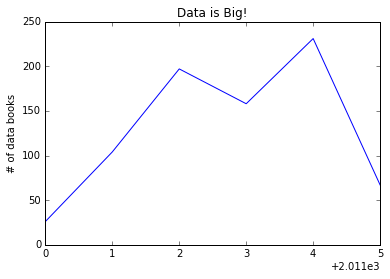

In [56]:
# USE SCRAPPED DATA: NUM OF BOOK PUBLISHED EACH YEAR
def get_year(book):
    # book['date'] returns 'Nov 2014', we therefore split on space and take 2nd.
    return int(book['date'].split()[1])
yearCounts = Counter(get_year(book) for book in books if get_year(book) <= 2016)
    # as of May 22, 2016:
    # Counter({2011: 26, 2012: 104, 2013: 197, 2014: 158, 2015: 231, 2016: 67})
years = sorted(yearCounts)
bookCounts = [yearCounts[year] for year in years]
plt.plot(years, bookCounts)
plt.ylabel('# of data books')
plt.title('Data is Big!')
plt.show()

### WEBDATA II: JSON, XML

In [64]:
# JSON: DESERIALIZED TO CREATE A PYTHON DICT
serialized = '''
    { "title": "Data Science Book",
      "author": "Joel Grus",
      "publicationYear": 2014,
      "topics": ["data", "science", "data science"]
    }
'''
deserialized = json.loads(serialized)
deserialized

{u'author': u'Joel Grus',
 u'publicationYear': 2014,
 u'title': u'Data Science Book',
 u'topics': [u'data', u'science', u'data science']}

In [71]:
endpoint = "https://api.github.com/users/joelgrus/repos"
repos = json.loads(requests.get(endpoint).text)
dates = [ parse(repo['created_at']) for repo in repos ]
    # parse target: u'created_at': u'2013-07-05T02:02:28Z'
    # parse result: datetime.datetime(2013, 7, 5, 2, 2, 28, tzinfo=tzutc())
monthCounts = Counter(date.month for date in dates)
weekdayCounts = Counter(date.weekday() for date in dates)

In [ ]:
# XML
#   similar to HTML, need to know how to use BeautifulSoup to handle processing.

In [78]:
last5Repos = sorted(repos, key=lambda r: r['created_at'], reverse=True)[:5]
last5Langs = [repo['language'] for repo in last5Repos]

[u'PureScript', u'JavaScript', u'HTML', u'PureScript', u'PureScript']

In [81]:
dates[:5]

[datetime.datetime(2013, 7, 5, 2, 2, 28, tzinfo=tzutc()),
 datetime.datetime(2013, 11, 15, 5, 33, 22, tzinfo=tzutc()),
 datetime.datetime(2012, 9, 18, 4, 20, 23, tzinfo=tzutc()),
 datetime.datetime(2015, 11, 11, 14, 15, 36, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 30, 0, 33, 3, tzinfo=tzutc())]

### WEBDATE III: API

In [92]:
# TWITTER
#   pip install twython

In [95]:
# MY TWITTER ACCOUNT (jacobsuwang)
KEYS = \
{ "CONSUMER_KEY": "CONFIDENTIAL",
  "CONSUMER_SECRET": "CONFIDENTIAL",
  "ACCESS_TOKEN": "CONFIDENTIAL",
  "ACCESS_TOKEN_SECRET": "CONFIDENTIAL"
}

In [97]:
# (LIMITED) ACCESS DATA BY KEYWORD
twitter = Twython(KEYS['CONSUMER_KEY'], KEYS['CONSUMER_SECRET'])
for status in twitter.search(q='"data science"')["statuses"]:
    user = status["user"]["screen_name"].encode('utf-8') 
        # utf-8 encoding is crucial in handling Unicode chars print cannot handle.
    text = status["text"].encode('utf-8')
    print user, ":", text
    print

LoopGM : RT @knoyd_com: #tweet2vec models for #nlp https://t.co/DKsGFSq3kc #machinelearning #datascience

ArkangelScrap : RT @EasyAnalytics1: #DataScience Job Roles Across Organizational Levels @bobehayes https://t.co/rfGgljOpWk #data #analytics

modernscientist : This is devastating. Please let the Python and data science communities know if we can help. https://t.co/FIQOQeLrzW

pinkporridge3 : RT @daveholtz: Speaking at #ODSC today about what data science actually is, because, well, who knows? 🤔

dparente : A Linear Method for Non-Linear Work: @microsoft  #DataScience Process

https://t.co/ZUIKrJyyhF

FmFrancoise : RT @mikegbuck: Top 10 #DataScience Influencers on Twitter #bigdata #IoThttp://buff.ly/1XKKQwX https://t.co/ak0XzvmS7C https://t.co/14UG9WRw…

BigDataTweetBot : RT @TjeerdHobma: 5 Ways to Tell if You’re Having a #BigData Problem or Just a ‘Lots of Data’ Problem. https://t.co/PfidSeUBqS https://t.co/…

pjgonzalo : RT @jvabad: Why is data science so hot right now? - https://t

In [102]:
# UNLIMITTED ACCESS: STREAMING
tweets = []
class MyStreamer(TwythonStreamer):
    # specifies how to interact with the stream.
    
    def on_success(self, data):
        # on receiving data, data will be a Python dict representing a tweet.
        if data['lang'] == 'en':
            tweets.append(data)
            print "received tweet #", len(tweets)
        if len(tweets) > 10: # N = 10, max tweet number.
            self.disconnect()
    
    def on_error(self, statusCode, data):
        print statusCode, data
        self.disconnect()

stream = MyStreamer(KEYS['CONSUMER_KEY'], KEYS['CONSUMER_SECRET'],
                    KEYS['ACCESS_TOKEN'], KEYS['ACCESS_TOKEN_SECRET'])
stream.statuses.filter(track='data') 
    # start consuming public statuses that contain 'data'.
    # if, instead we wanted to start consuming a sample of *all* public statuses.
    # stream.statuses.sample()
    # this will run until we collect N tweets.
topHashtags = Counter(hashtag['text'].lower() for tweet in tweets for hashtag in tweet['entities']['hashtags'])
print topHashtags.most_common(5)


received tweet # 1
received tweet # 2
received tweet # 3
received tweet # 4
received tweet # 5
received tweet # 6
received tweet # 7
received tweet # 8
received tweet # 9
received tweet # 10
received tweet # 11
[('data', 4), ('bluemix', 1), ('lemuel', 1), ('javascript', 1), ('bigdata', 1)]
